In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [1]:
#%pip install seaborn


Columns with NaN values:
challenges_junglerKillsEarlyJungle              74
challenges_killsOnLanersEarlyJungleAsJungler    74
dtype: int64


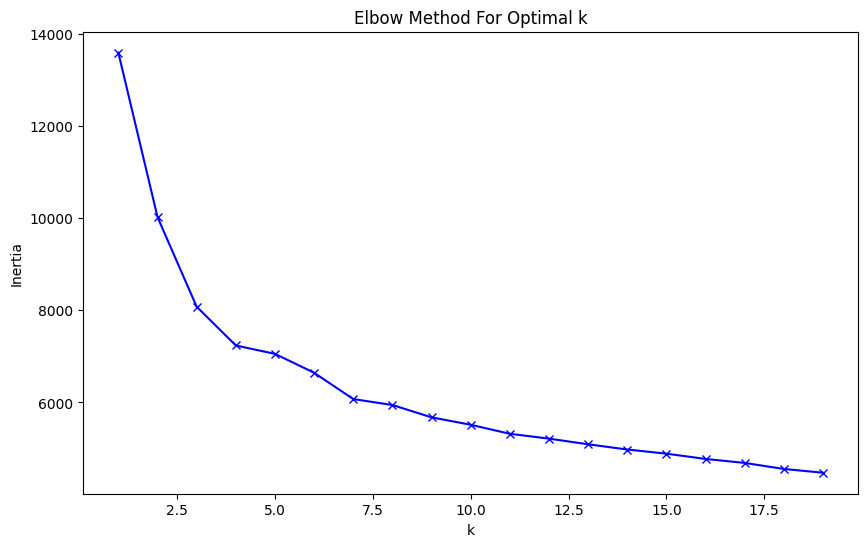

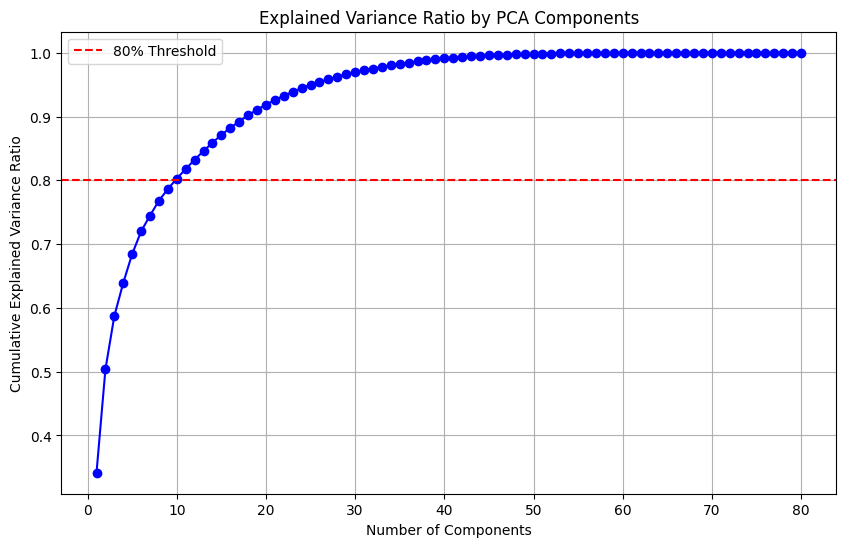

Number of components needed to explain 80% of variance: 10


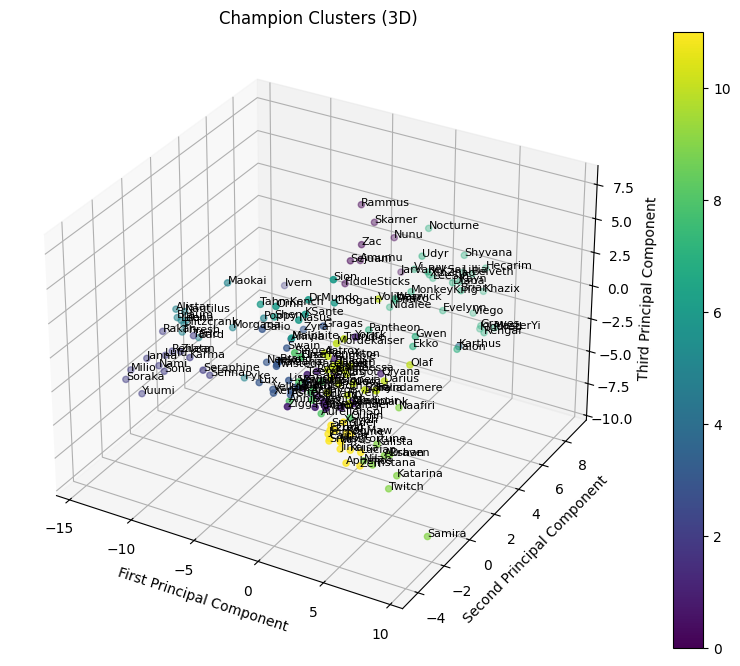


=== Cluster 0 ===

Champions in this cluster:
Amumu, FiddleSticks, JarvanIV, Nunu, Rammus, Sejuani, Skarner, Zac

Distinctive features:
damageSelfMitigated            41248.94250
totalDamageTaken               35187.90500
damageDealtToObjectives        23354.12125
totalDamageDealtToChampions    16522.08500
goldEarned                     10380.90250
Name: 0, dtype: float64
--------------------------------------------------

=== Cluster 1 ===

Champions in this cluster:
Ahri, Akali, Aurora, Fizz, Heimerdinger, Kennen, Leblanc, Mel, Qiyana, Rumble, Ryze, Sylas, Teemo, Vex, Viktor, Vladimir, Yorick, Zed, Ziggs

Distinctive features:
totalDamageDealtToChampions    23618.372105
totalDamageTaken               22950.188947
magicDamageDealtToChampions    18368.864211
damageSelfMitigated            14042.155263
goldEarned                     11293.547368
Name: 1, dtype: float64
--------------------------------------------------

=== Cluster 2 ===

Champions in this cluster:
Ivern, Janna, Karma,

In [3]:
# Read the data
df = pd.read_csv('champion_stats.csv')

# Select features for clustering
features = [
    # Combat Stats
    'kills', 'deaths', 'assists', 'kda',
    'doubleKills', 'tripleKills', 'quadraKills', 'pentaKills',
    'challenges_killParticipation', 'challenges_takedowns',
    'challenges_soloKills', 'challenges_quickSoloKills',
    'challenges_outnumberedKills', 'challenges_takedownsAfterGainingLevelAdvantage',
    
    # Damage Stats
    'totalDamageDealtToChampions', 'totalDamageTaken',
    'magicDamageDealtToChampions', 'physicalDamageDealtToChampions', 'trueDamageDealtToChampions',
    'damageSelfMitigated', 'damage_per_minute',
    'largestCriticalStrike', 'challenges_teamDamagePercentage', 'challenges_damageTakenOnTeamPercentage',
    'pct_highest_dmg_in_match',
    
    # Support/Utility Stats
    'timeCCingOthers', 'totalHealsOnTeammates', 'totalDamageShieldedOnTeammates',
    'challenges_effectiveHealAndShielding', 'challenges_enemyChampionImmobilizations',
    'pct_highest_cc_in_match', 'challenges_saveAllyFromDeath',
    
    # Economy Stats
    'goldEarned', 'goldSpent', 'totalMinionsKilled',
    'neutralMinionsKilled', 'cs_per_minute', 'gold_per_minute',
    'challenges_laneMinionsFirst10Minutes', 'challenges_jungleCsBefore10Minutes',
    'challenges_maxCsAdvantageOnLaneOpponent',
    
    # Vision Stats
    'visionScore', 'wardsPlaced', 'wardsKilled', 'visionWardsBoughtInGame',
    'detectorWardsPlaced', 'challenges_visionScorePerMinute', 'pct_highest_ward_kills_in_match',
    'challenges_controlWardTimeCoverageInRiverOrEnemyHalf',
    
    # Objective Stats
    'team_first_baron_rate', 'team_first_dragon_rate', 'team_first_tower_rate', 'team_first_herald_rate',
    'damageDealtToBuildings', 'damageDealtToObjectives', 'challenges_turretPlatesTaken',
    'challenges_epicMonsterSteals', 'challenges_epicMonsterKillsWithin30SecondsOfSpawn',
    
    # Jungle Stats
    'challenges_buffsStolen', 'challenges_initialBuffCount', 'challenges_initialCrabCount',
    'challenges_scuttleCrabKills', 'challenges_junglerKillsEarlyJungle',
    'challenges_killsOnLanersEarlyJungleAsJungler',
    
    # Survival Stats
    'longestTimeSpentLiving', 'bountyLevel', 'totalTimeSpentDead',
    'challenges_survivedSingleDigitHpCount', 'challenges_survivedThreeImmobilizesInFight',
    'challenges_tookLargeDamageSurvived',
    
    # Early Game Stats
    'challenges_earlyLaningPhaseGoldExpAdvantage', 'challenges_laningPhaseGoldExpAdvantage',
    'challenges_maxLevelLeadLaneOpponent', 'first_blood_rate', 'first_tower_kill_rate',
    
    # Multikill Stats
    'killingSprees', 'largestKillingSpree', 'challenges_multikills',
    'challenges_multiKillOneSpell', 'challenges_legendaryCount'
]

# Check which features exist in the dataframe
available_features = [f for f in features if f in df.columns]
missing_features = [f for f in features if f not in df.columns]

if missing_features:
    print(f"Warning: The following features are not in the dataset and will be skipped: {missing_features}")

# Use only available features
features = available_features

# Prepare the data
X = df[features].copy()

# Check for NaN values
nan_counts = X.isna().sum()
print("\nColumns with NaN values:")
print(nan_counts[nan_counts > 0])

# Handle missing values by imputing with mean
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Now standardize the imputed data
X = StandardScaler().fit_transform(X_imputed)

# Elbow method to find optimal number of clusters
inertias = []
K = range(1, 20)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)

# Plot elbow curve
plt.figure(figsize=(10, 6))
plt.plot(K, inertias, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

# Perform k-means clustering
n_clusters = 12  # You can adjust this based on the elbow plot
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df['Cluster'] = kmeans.fit_predict(X)

# Analyze PCA components
pca = PCA()
X_pca = pca.fit_transform(X)

# Calculate explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# Plot explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance_ratio, 'bo-')
plt.axhline(y=0.80, color='r', linestyle='--', label='80% Threshold')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Explained Variance Ratio by PCA Components')
plt.legend()
plt.grid(True)
plt.show()

# Find number of components needed for 80% variance
n_components_80 = np.argmax(cumulative_variance_ratio >= 0.80) + 1
print(f"Number of components needed to explain 80% of variance: {n_components_80}")

# Create visualization using first 3 components (if we have enough dimensions)
if X_pca.shape[1] >= 3:
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], 
                        c=df['Cluster'], cmap='viridis')
    ax.set_xlabel('First Principal Component')
    ax.set_ylabel('Second Principal Component')
    ax.set_zlabel('Third Principal Component')
    plt.title('Champion Clusters (3D)')
    
    # Add champion names as annotations (optional - can be cluttered in 3D)
    for i, champion in enumerate(df['championName']):
        ax.text(X_pca[i, 0], X_pca[i, 1], X_pca[i, 2], champion, fontsize=8)
    
    plt.colorbar(scatter)
    plt.show()


# Calculate cluster means
cluster_means = df.groupby('Cluster')[features].mean()

# Print clusters and their characteristics
for cluster in range(n_clusters):
    print(f"\n=== Cluster {cluster} ===")
    print("\nChampions in this cluster:")
    cluster_champs = df[df['Cluster'] == cluster]['championName'].tolist()
    print(', '.join(sorted(cluster_champs)))
    
    print("\nDistinctive features:")
    cluster_features = cluster_means.loc[cluster]
    sorted_features = cluster_features.sort_values(ascending=False)
    print(sorted_features.head())
    print("-" * 50)

K-Means Silhouette Score: 0.155
Hierarchical Silhouette Score: 0.137
Gaussian Mixture Silhouette Score: 0.155


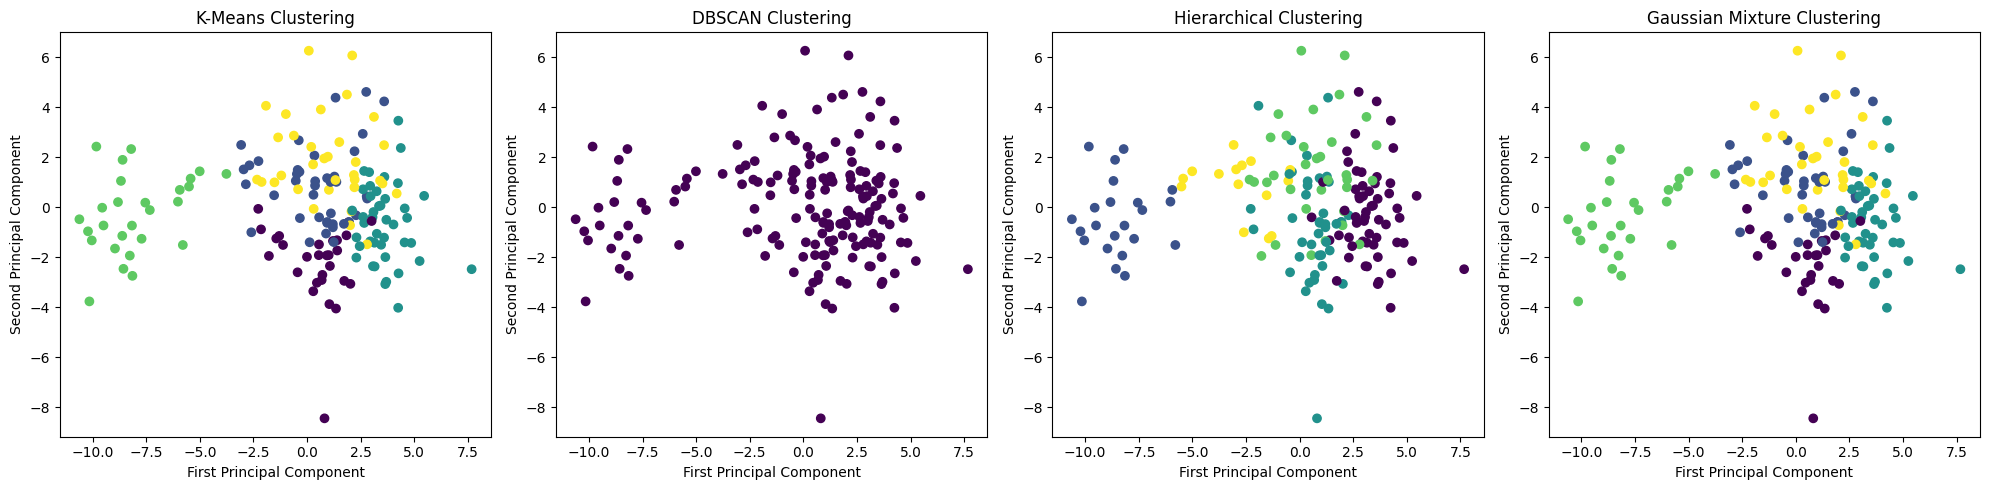

In [10]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt

# Prepare data (using existing X from previous code)
clustering_methods = {
    'K-Means': KMeans(n_clusters=5, random_state=42),
    'DBSCAN': DBSCAN(eps=2.5, min_samples=3),
    'Hierarchical': AgglomerativeClustering(n_clusters=5),
    'Gaussian Mixture': GaussianMixture(n_components=5, random_state=42)
}

# Compare clustering methods
plt.figure(figsize=(20, 5))
for idx, (name, model) in enumerate(clustering_methods.items(), 1):
    plt.subplot(1, 4, idx)
    
    # Fit the model
    if name == 'Gaussian Mixture':
        labels = model.fit_predict(X)
    else:
        labels = model.fit_predict(X)
    
    # Calculate silhouette score (except for DBSCAN which might have -1 labels)
    if name != 'DBSCAN':
        score = silhouette_score(X, labels)
        print(f"{name} Silhouette Score: {score:.3f}")
    
    # Plot first two PCA components colored by cluster
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis')
    plt.title(f'{name} Clustering')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')

plt.tight_layout()
plt.show()

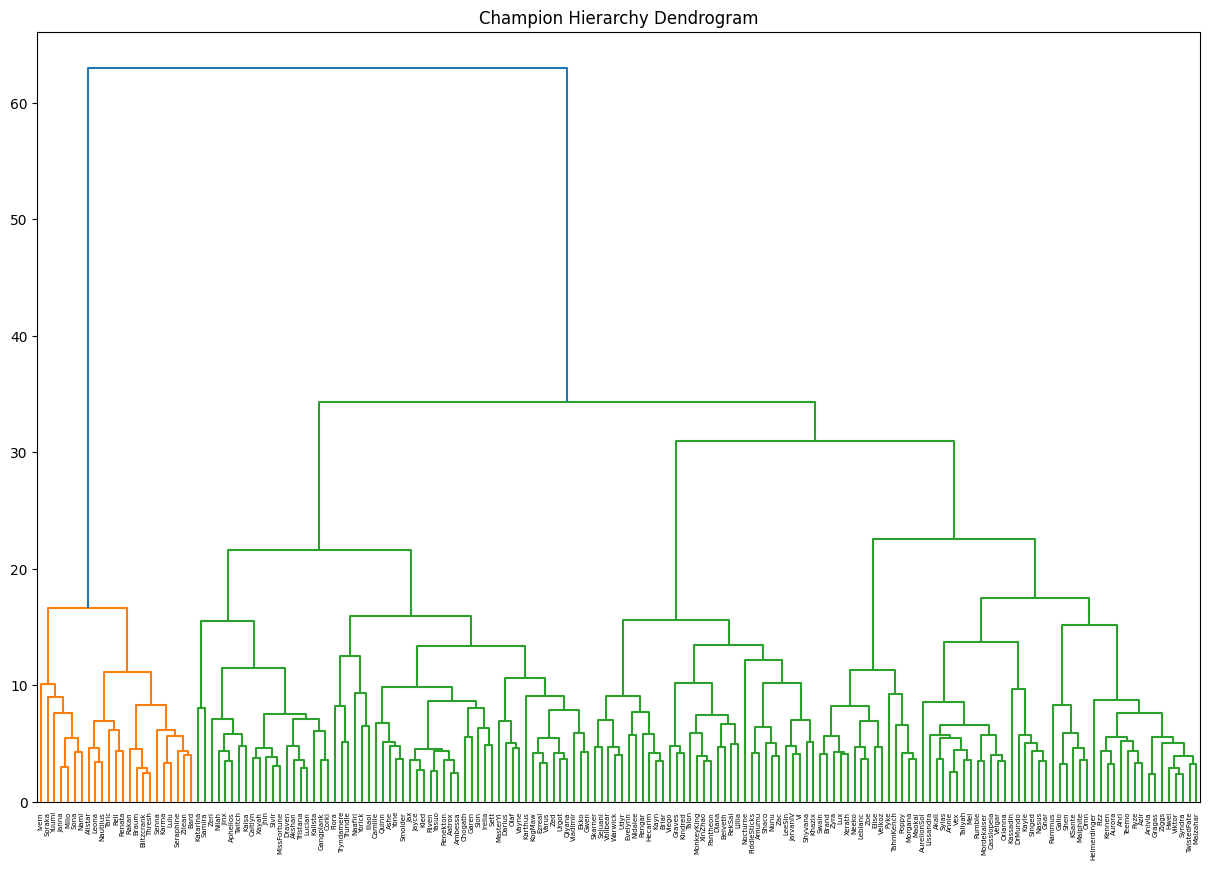


Most Hybrid Champions (highest mixture of playstyles):
       Champion  Hybrid Score
0         Annie -1.000000e-10
1          Olaf -1.000000e-10
2         Galio -1.000000e-10
3   TwistedFate -1.000000e-10
4       XinZhao -1.000000e-10
5         Urgot -1.000000e-10
6       Leblanc -1.000000e-10
7      Vladimir -1.000000e-10
8  FiddleSticks -1.000000e-10
9         Kayle -1.000000e-10


In [11]:
# For Hierarchical Clustering, show dendrogram
from scipy.cluster.hierarchy import dendrogram, linkage

plt.figure(figsize=(15, 10))
linkage_matrix = linkage(X, 'ward')
dendrogram(linkage_matrix, labels=df['championName'].values)
plt.title('Champion Hierarchy Dendrogram')
plt.xticks(rotation=90)
plt.show()

# For Gaussian Mixture, show probability distribution
if 'Gaussian Mixture' in clustering_methods:
    gmm = clustering_methods['Gaussian Mixture']
    probs = gmm.predict_proba(X)
    
    # Show champions with highest mixture of playstyles
    hybrid_scores = -np.sum(probs * np.log(probs + 1e-10), axis=1)  # entropy
    most_hybrid = pd.DataFrame({
        'Champion': df['championName'],
        'Hybrid Score': hybrid_scores
    }).sort_values('Hybrid Score', ascending=False)
    
    print("\nMost Hybrid Champions (highest mixture of playstyles):")
    print(most_hybrid.head(10))

In [4]:
# Create a more detailed cluster profile
def analyze_cluster_profiles(df, cluster_means, features, n_clusters):
    # Create a dictionary to store cluster profiles
    cluster_profiles = {}
    
    # Calculate global means for comparison
    global_means = df[features].mean()
    
    # Calculate standard deviations for normalization
    global_stds = df[features].std()
    
    for cluster in range(n_clusters):
        # Get champions in this cluster
        cluster_champs = df[df['Cluster'] == cluster]['championName'].tolist()
        
        # Calculate z-scores (how many standard deviations from mean)
        z_scores = (cluster_means.loc[cluster] - global_means) / global_stds
        
        # Get top distinctive features (both high and low)
        top_high = z_scores.nlargest(10)
        top_low = z_scores.nsmallest(10)
        
        # Store in profile dictionary
        cluster_profiles[cluster] = {
            'champions': sorted(cluster_champs),
            'size': len(cluster_champs),
            'distinctive_high': top_high,
            'distinctive_low': top_low,
            'raw_means': cluster_means.loc[cluster]
        }
        
        # Print detailed profile
        print(f"\n=== DETAILED PROFILE: Cluster {cluster} ({len(cluster_champs)} champions) ===")
        print("\nChampions in this cluster:")
        print(', '.join(sorted(cluster_champs)))
        
        print("\nWhat makes this cluster UNIQUE (highest z-scores):")
        for feature, score in top_high.items():
            actual_value = cluster_means.loc[cluster, feature]
            print(f"  {feature}: {actual_value:.2f} (z-score: {score:.2f})")
        
        print("\nWhat this cluster LACKS (lowest z-scores):")
        for feature, score in top_low.items():
            actual_value = cluster_means.loc[cluster, feature]
            print(f"  {feature}: {actual_value:.2f} (z-score: {score:.2f})")
            
    return cluster_profiles

# Run the detailed analysis
cluster_profiles = analyze_cluster_profiles(df, cluster_means, features, n_clusters)

# Save the cluster profiles for later use by the chat agent
import pickle
with open('champion_cluster_profiles.pkl', 'wb') as f:
    pickle.dump({
        'profiles': cluster_profiles,
        'feature_descriptions': {
            # Add human-readable descriptions for each feature
            'kills': 'Average kills per game',
            'deaths': 'Average deaths per game',
            'assists': 'Average assists per game',
            'kda': 'Kill/Death/Assist ratio',
            # Add more descriptions here
        },
        'cluster_summaries': {
            # After analyzing the data, you can add human-written summaries here
            # 0: "Tanky frontline champions who excel at absorbing damage and providing crowd control",
            # 1: "Burst mages with high magical damage output but low survivability",
            # Add more as you analyze the results
        }
    }, f)



=== DETAILED PROFILE: Cluster 0 (8 champions) ===

Champions in this cluster:
Amumu, FiddleSticks, JarvanIV, Nunu, Rammus, Sejuani, Skarner, Zac

What makes this cluster UNIQUE (highest z-scores):
  damageSelfMitigated: 41248.94 (z-score: 1.68)
  challenges_epicMonsterSteals: 0.07 (z-score: 1.68)
  challenges_initialBuffCount: 1.57 (z-score: 1.66)
  challenges_initialCrabCount: 0.75 (z-score: 1.57)
  challenges_jungleCsBefore10Minutes: 45.79 (z-score: 1.56)
  challenges_buffsStolen: 5.97 (z-score: 1.48)
  neutralMinionsKilled: 112.28 (z-score: 1.47)
  challenges_scuttleCrabKills: 2.38 (z-score: 1.42)
  challenges_damageTakenOnTeamPercentage: 0.28 (z-score: 1.34)
  challenges_enemyChampionImmobilizations: 44.77 (z-score: 1.19)

What this cluster LACKS (lowest z-scores):
  challenges_turretPlatesTaken: 0.47 (z-score: -1.37)
  challenges_laneMinionsFirst10Minutes: 10.68 (z-score: -1.27)
  totalMinionsKilled: 40.48 (z-score: -1.20)
  pct_highest_dmg_in_match: 1.21 (z-score: -1.13)
  chall

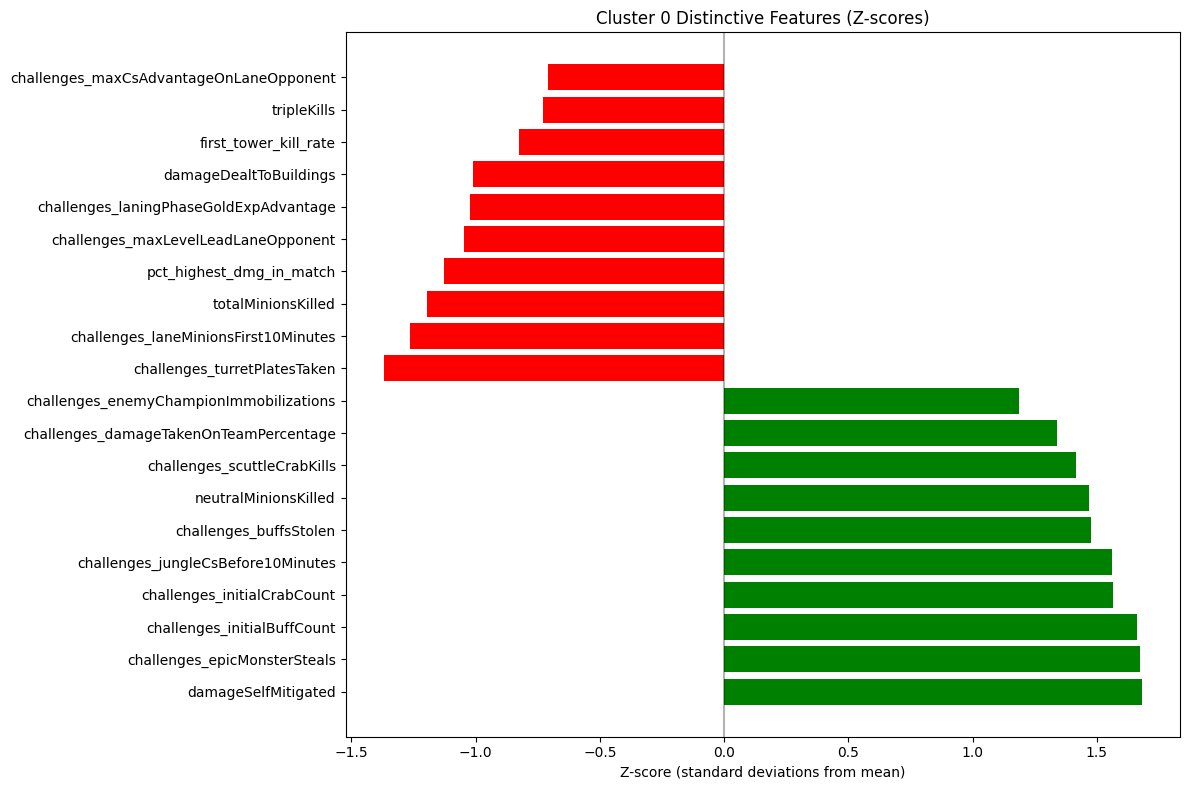

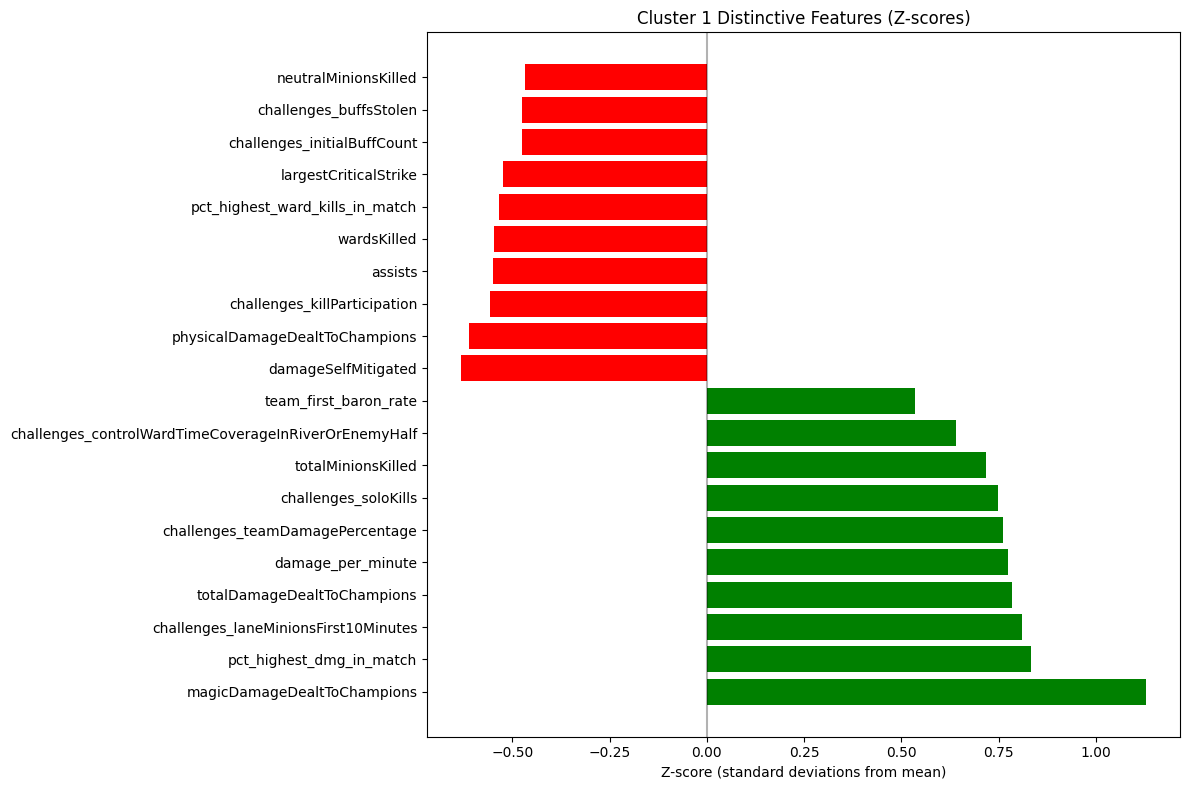

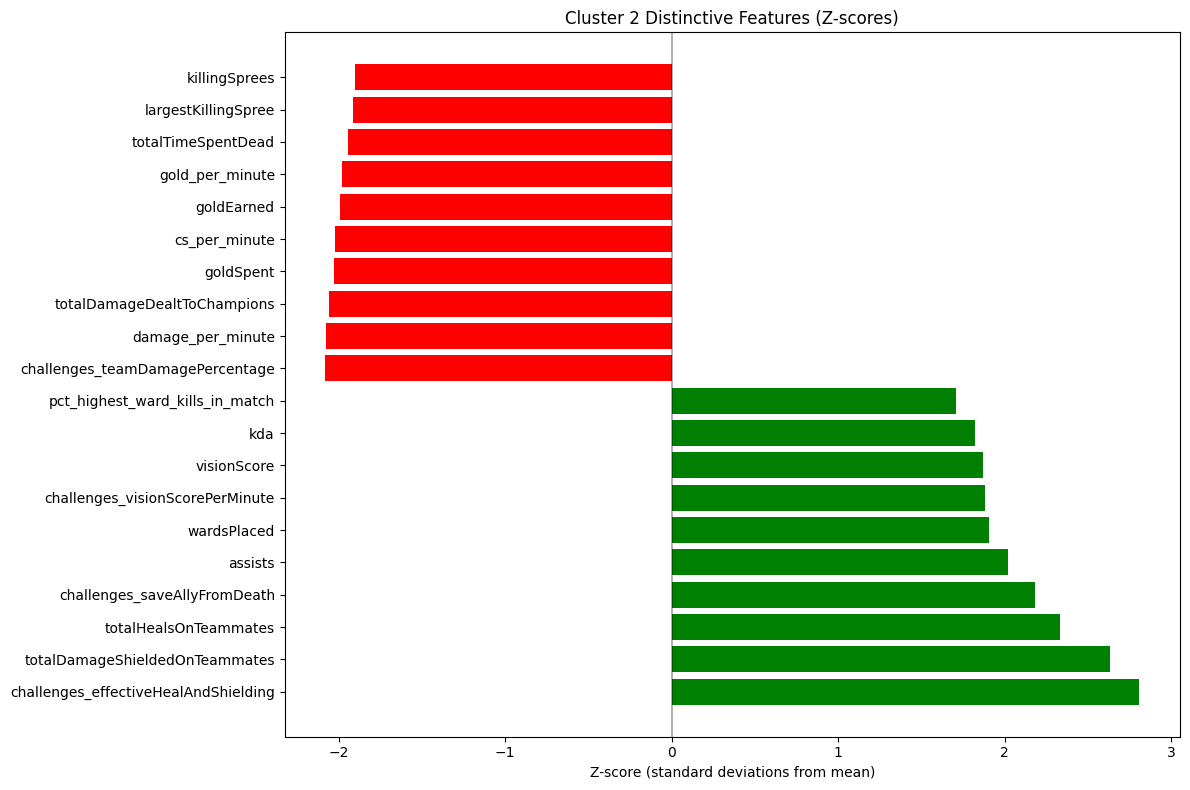

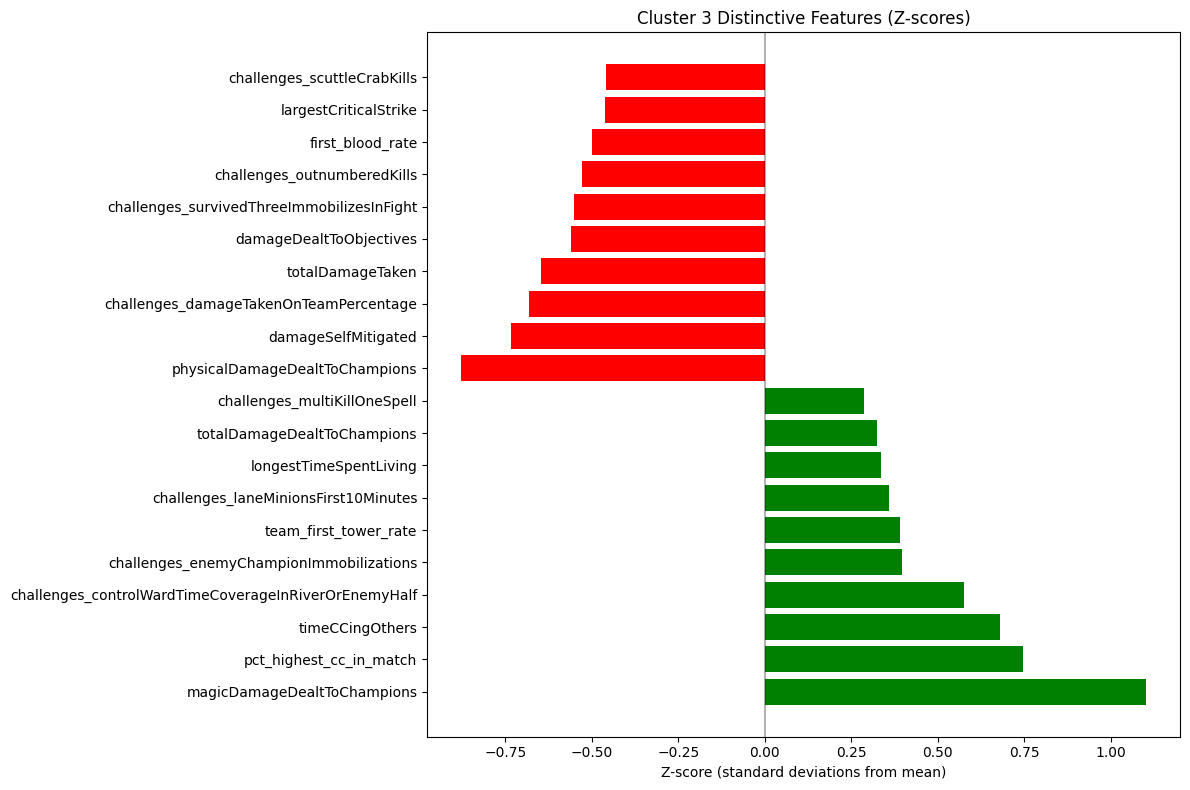

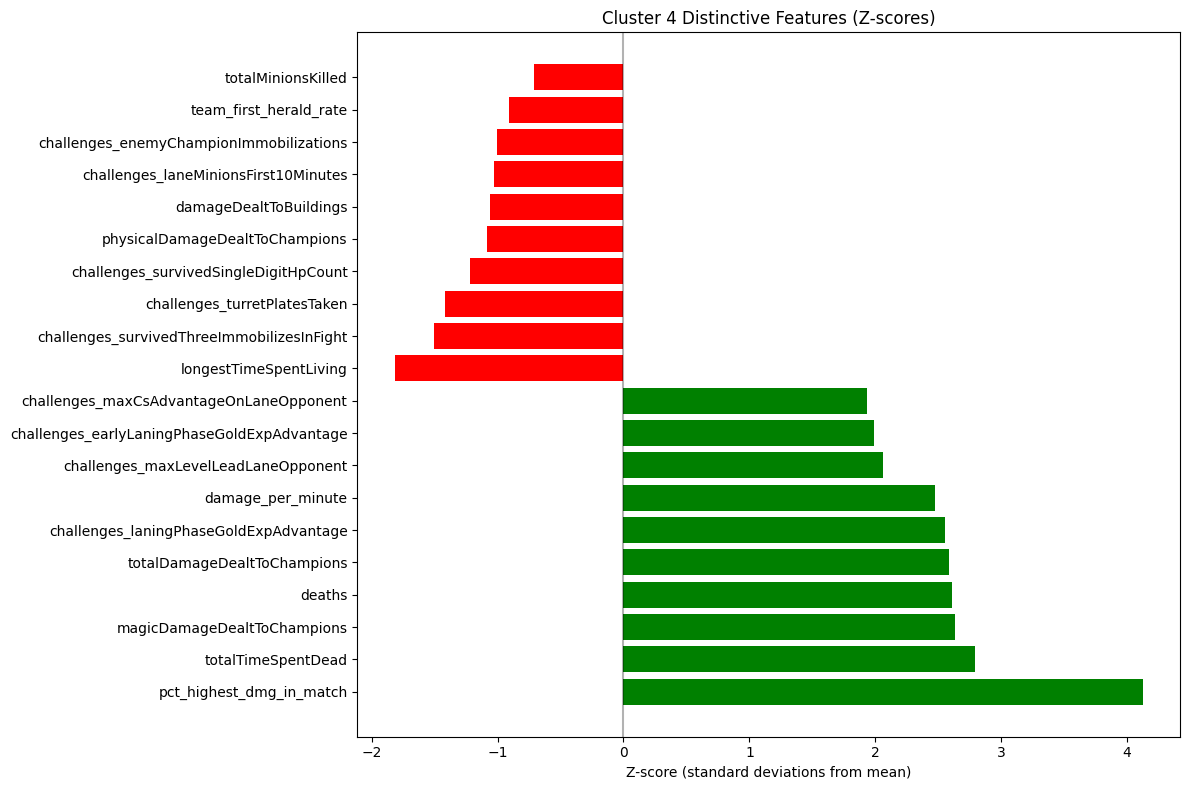

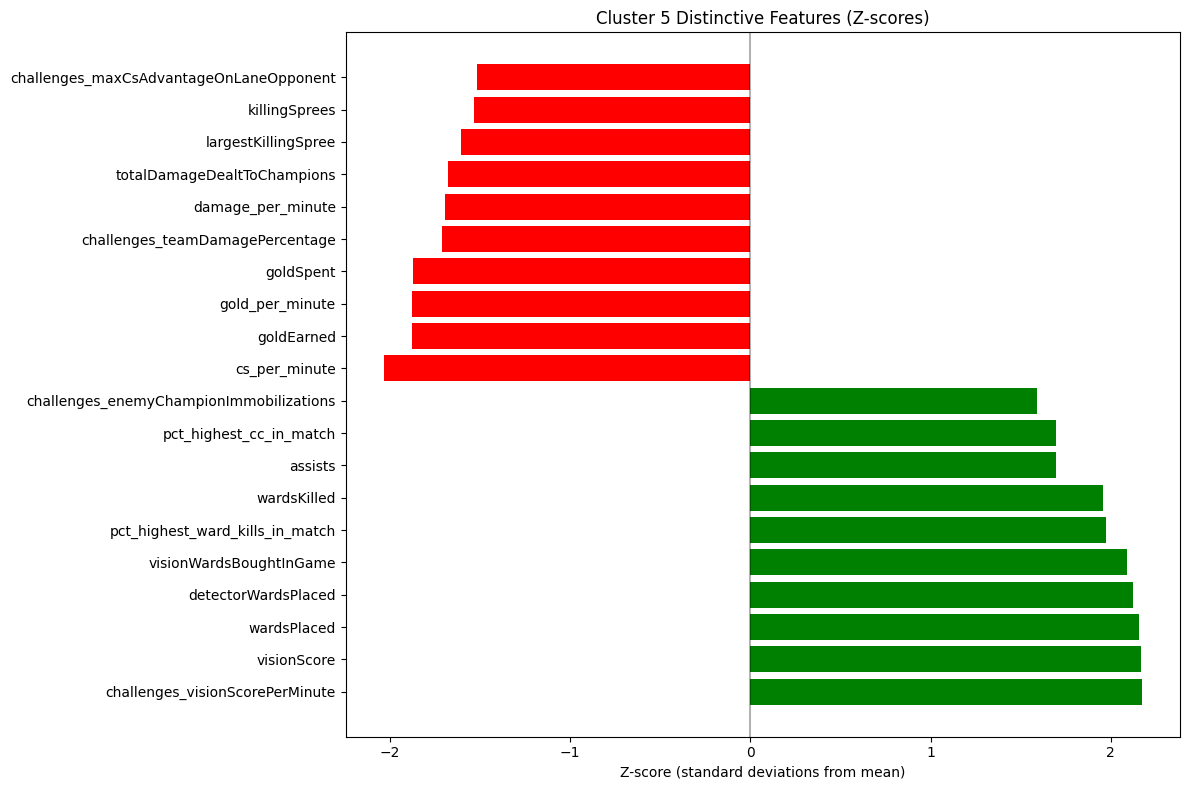

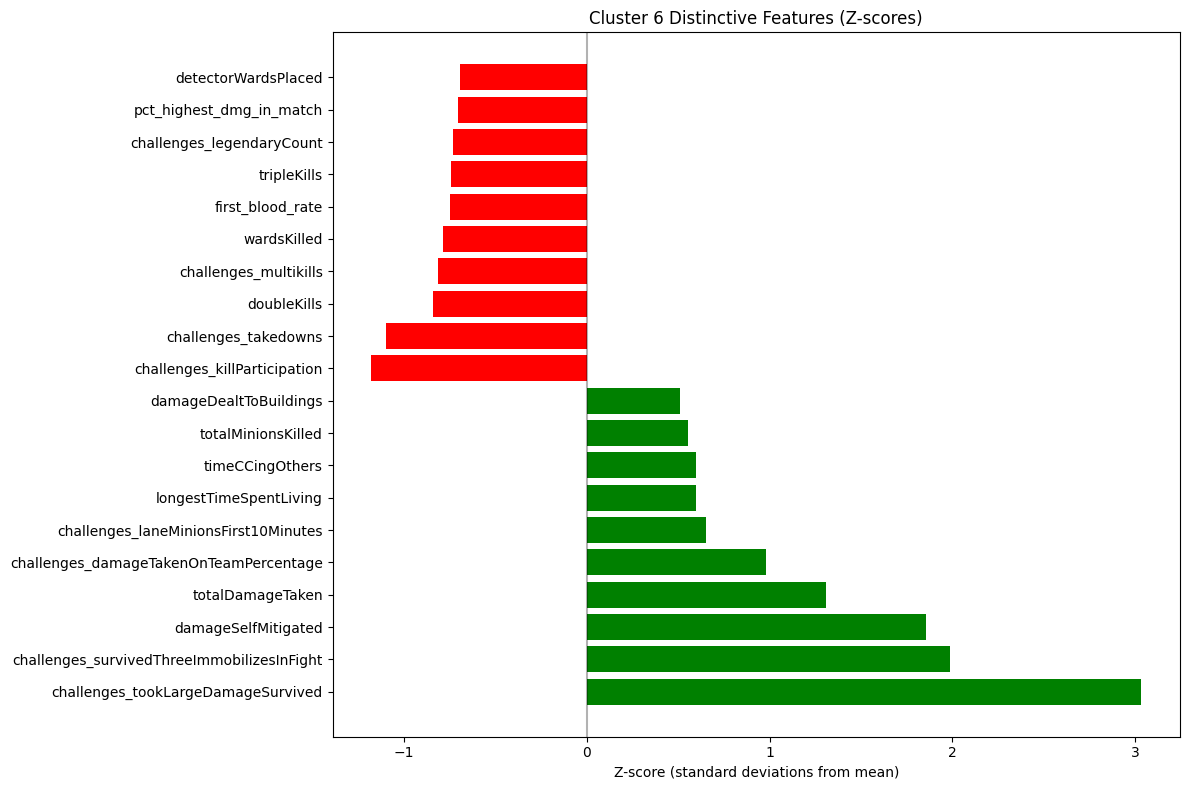

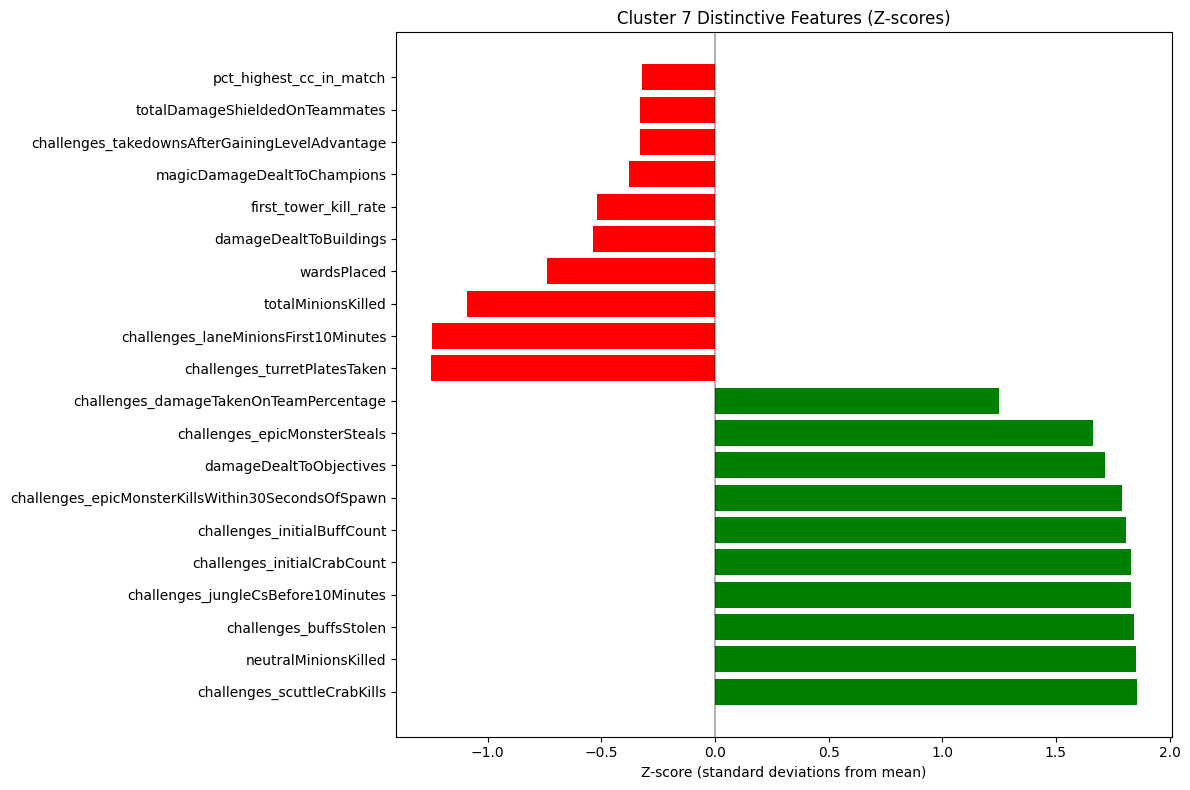

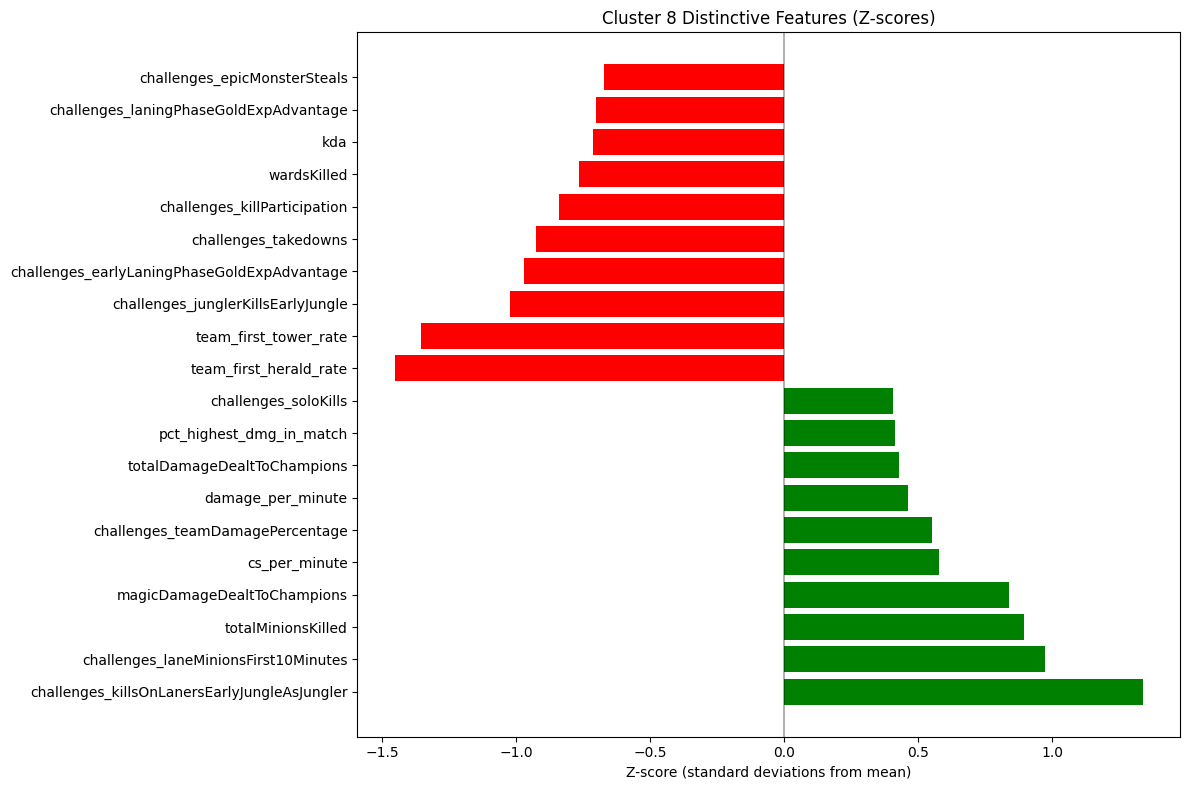

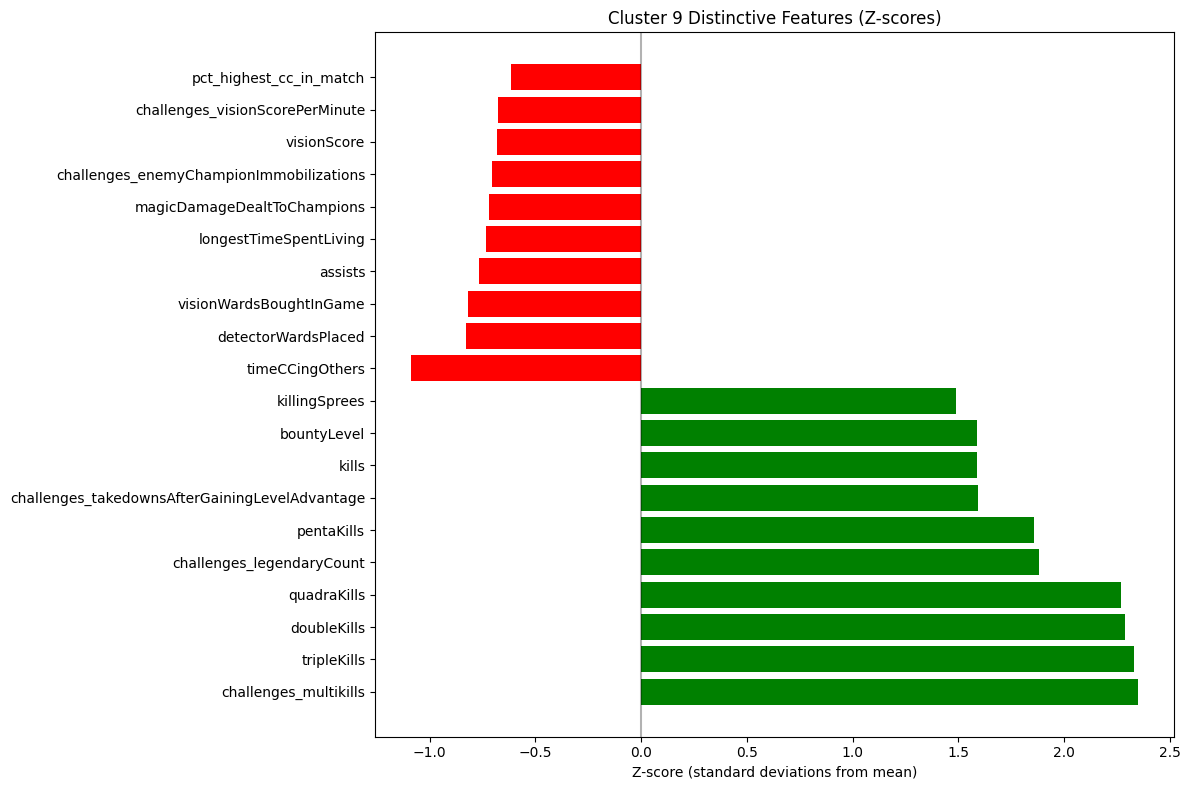

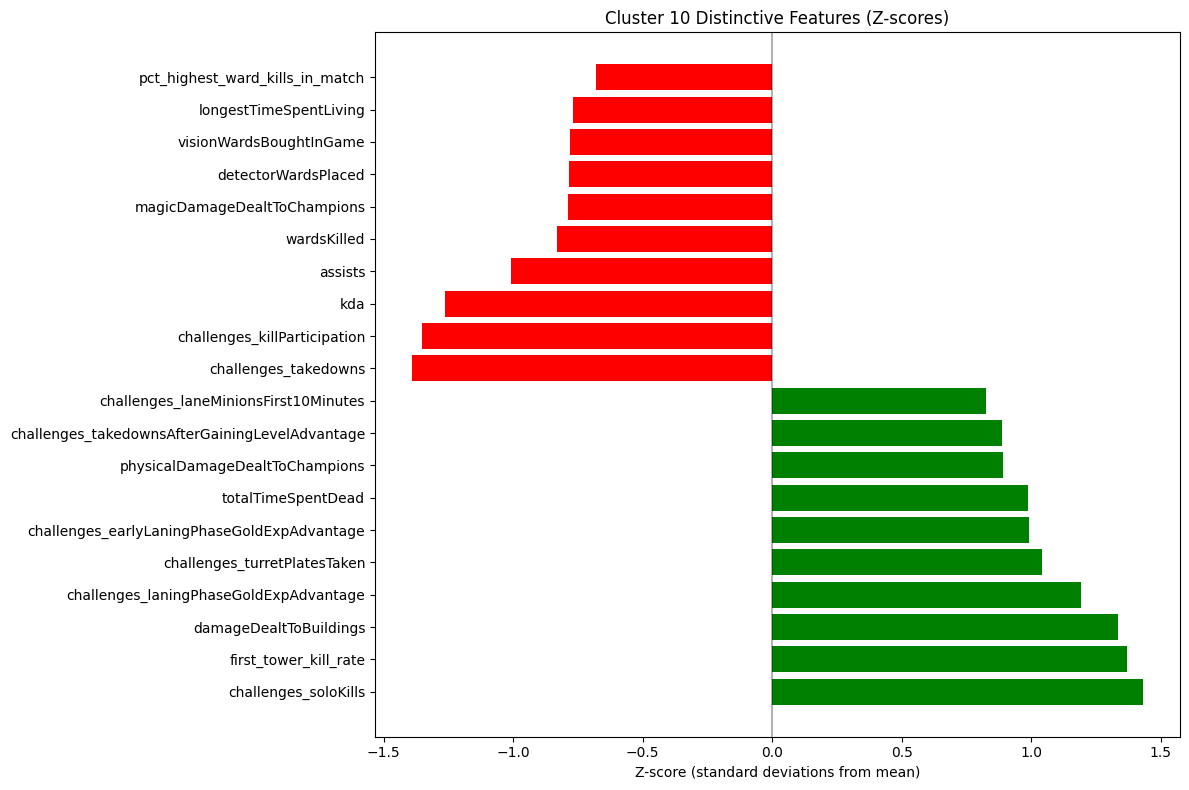

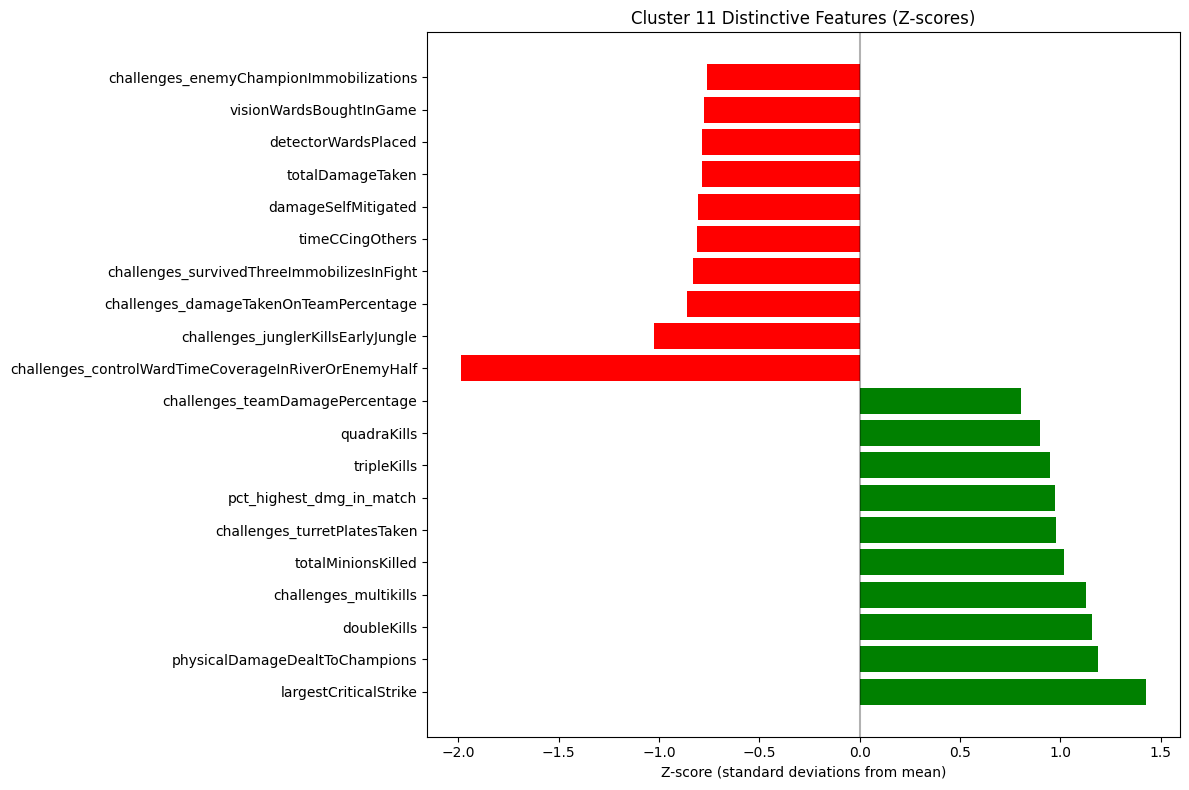

In [5]:
# Add this visualization to better understand what defines each cluster
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_cluster_features(cluster_profiles, cluster_to_visualize=None):
    if cluster_to_visualize is not None:
        clusters_to_show = [cluster_to_visualize]
    else:
        clusters_to_show = list(cluster_profiles.keys())
    
    for cluster in clusters_to_show:
        profile = cluster_profiles[cluster]
        
        # Combine high and low features
        all_features = pd.concat([profile['distinctive_high'], profile['distinctive_low']])
        
        plt.figure(figsize=(12, 8))
        bars = plt.barh(all_features.index, all_features.values, color=['green' if x > 0 else 'red' for x in all_features.values])
        plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
        plt.title(f'Cluster {cluster} Distinctive Features (Z-scores)')
        plt.xlabel('Z-score (standard deviations from mean)')
        plt.tight_layout()
        plt.show()

# Visualize all clusters or a specific one
visualize_cluster_features(cluster_profiles)
# Or for a specific cluster: visualize_cluster_features(cluster_profiles, 0)

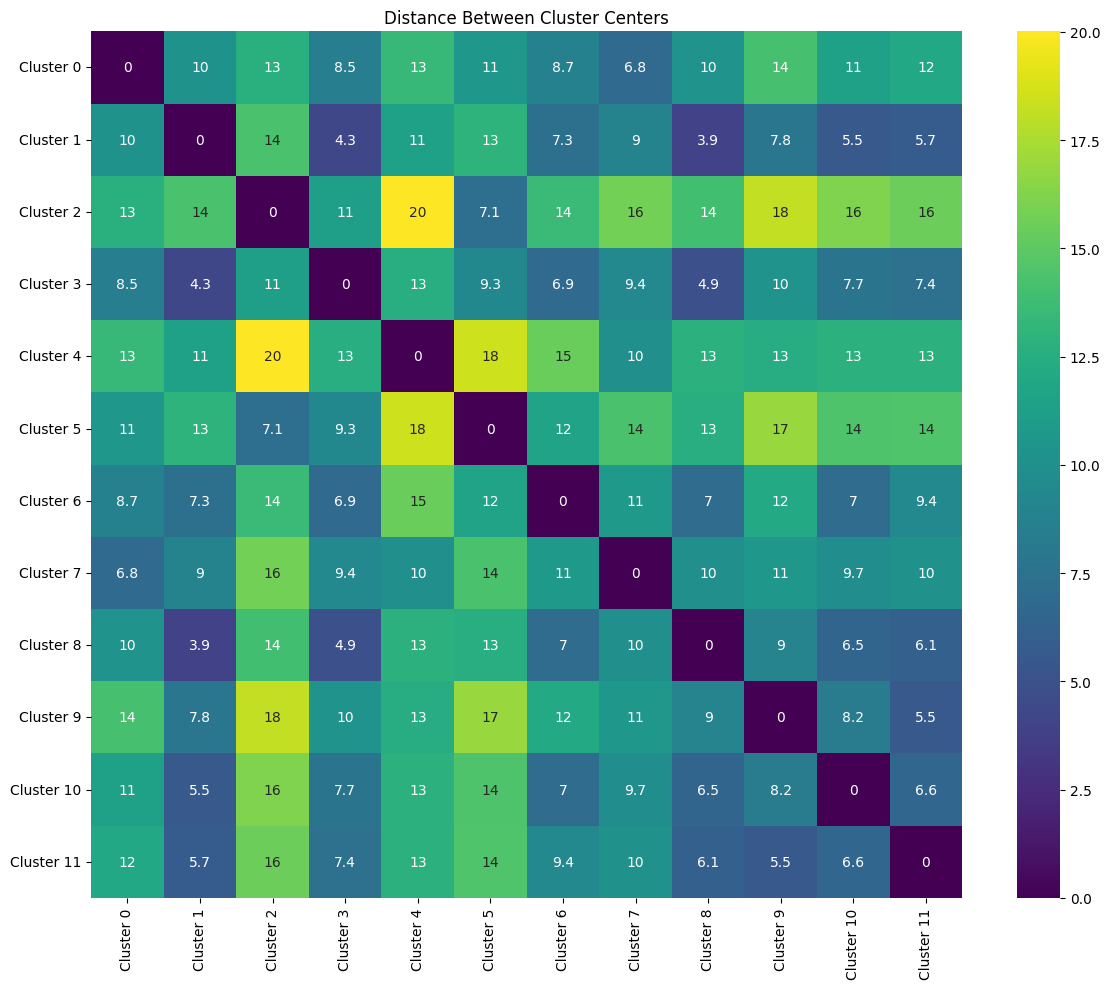


Cluster 0 is most similar to:
  Cluster 7 (distance: 6.83)
  Cluster 3 (distance: 8.46)
  Cluster 6 (distance: 8.73)

Cluster 1 is most similar to:
  Cluster 8 (distance: 3.94)
  Cluster 3 (distance: 4.28)
  Cluster 10 (distance: 5.53)

Cluster 2 is most similar to:
  Cluster 5 (distance: 7.12)
  Cluster 3 (distance: 11.24)
  Cluster 0 (distance: 12.71)

Cluster 3 is most similar to:
  Cluster 1 (distance: 4.28)
  Cluster 8 (distance: 4.89)
  Cluster 6 (distance: 6.87)

Cluster 4 is most similar to:
  Cluster 7 (distance: 9.95)
  Cluster 1 (distance: 11.38)
  Cluster 9 (distance: 12.51)

Cluster 5 is most similar to:
  Cluster 2 (distance: 7.12)
  Cluster 3 (distance: 9.35)
  Cluster 0 (distance: 10.66)

Cluster 6 is most similar to:
  Cluster 3 (distance: 6.87)
  Cluster 8 (distance: 6.98)
  Cluster 10 (distance: 7.00)

Cluster 7 is most similar to:
  Cluster 0 (distance: 6.83)
  Cluster 1 (distance: 8.98)
  Cluster 3 (distance: 9.41)

Cluster 8 is most similar to:
  Cluster 1 (dista

In [6]:
# Add this to understand relationships between clusters
from scipy.spatial.distance import pdist, squareform

# Calculate distances between cluster centers
cluster_centers = kmeans.cluster_centers_
cluster_distances = squareform(pdist(cluster_centers))

# Create a DataFrame for better visualization
cluster_distance_df = pd.DataFrame(
    cluster_distances, 
    index=[f'Cluster {i}' for i in range(n_clusters)],
    columns=[f'Cluster {i}' for i in range(n_clusters)]
)

# Visualize as a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(cluster_distance_df, annot=True, cmap='viridis')
plt.title('Distance Between Cluster Centers')
plt.tight_layout()
plt.show()

# Find the closest clusters for each cluster
for i in range(n_clusters):
    # Get distances to other clusters (excluding self)
    distances = cluster_distances[i]
    distances[i] = np.inf  # Exclude self
    
    # Find the 3 closest clusters
    closest_indices = np.argsort(distances)[:3]
    closest_distances = distances[closest_indices]
    
    print(f"\nCluster {i} is most similar to:")
    for idx, dist in zip(closest_indices, closest_distances):
        print(f"  Cluster {idx} (distance: {dist:.2f})")

In [7]:
# Add this to find similar champions across the dataset
from sklearn.metrics.pairwise import euclidean_distances

# Calculate distances between all champions
champion_distances = euclidean_distances(X_imputed)

# Create a DataFrame with champion names
champion_distance_df = pd.DataFrame(
    champion_distances,
    index=df['championName'],
    columns=df['championName']
)

# Function to find similar champions
def find_similar_champions(champion_name, n=5):
    if champion_name not in champion_distance_df.index:
        print(f"Champion {champion_name} not found!")
        return
    
    # Get distances to all other champions
    distances = champion_distance_df.loc[champion_name]
    
    # Sort and get the closest ones (excluding self)
    similar_champions = distances.sort_values()[1:n+1]
    
    print(f"Champions most similar to {champion_name}:")
    for champ, dist in similar_champions.items():
        print(f"  {champ} (distance: {dist:.2f})")
    
    return similar_champions

# Example usage
find_similar_champions('Ahri')
find_similar_champions('Darius')

Champions most similar to Ahri:
  Fizz (distance: 4448.56)
  Zoe (distance: 4729.71)
  Velkoz (distance: 4964.06)
  Leblanc (distance: 4988.21)
  Lissandra (distance: 5772.75)
Champions most similar to Darius:
  Camille (distance: 6241.28)
  Sett (distance: 6614.39)
  Kled (distance: 7181.87)
  Irelia (distance: 7391.20)
  Yone (distance: 7592.94)


championName
Camille    6241.276045
Sett       6614.385204
Kled       7181.872856
Irelia     7391.204199
Yone       7592.936298
Name: Darius, dtype: float64

In [8]:
# Add this after analyzing the clusters
cluster_descriptions = {
    0: {
        "name": "Tanky Frontliners",
        "description": "Champions who excel at absorbing damage and providing crowd control for their team.",
        "playstyle": "These champions typically build defensive items and focus on initiating fights and protecting allies.",
        "strengths": ["High survivability", "Good crowd control", "Team fight presence"],
        "weaknesses": ["Lower damage output", "Can be kited", "Dependent on team follow-up"],
        "recommended_for": "Players who enjoy being in the middle of fights and protecting their team."
    },
    # Add more clusters with detailed descriptions
}

# Save these descriptions for your chat agent
with open('champion_cluster_descriptions.pkl', 'wb') as f:
    pickle.dump(cluster_descriptions, f)

In [9]:
def recommend_champions_by_preferences(preferences, cluster_profiles, cluster_descriptions, top_n=5):
    """
    Recommend champions based on user preferences.
    
    Parameters:
    - preferences: dict of feature preferences (e.g., {'damage': 'high', 'survivability': 'medium'})
    - cluster_profiles: the cluster profiles generated earlier
    - cluster_descriptions: human-readable descriptions of clusters
    - top_n: number of champions to recommend
    
    Returns:
    - List of recommended champions with explanations
    """
    # Map user preferences to features
    feature_mapping = {
        'damage': ['totalDamageDealtToChampions', 'damage_per_minute'],
        'survivability': ['totalDamageTaken', 'damageSelfMitigated', 'longestTimeSpentLiving'],
        'utility': ['timeCCingOthers', 'totalHealsOnTeammates', 'totalDamageShieldedOnTeammates'],
        'mobility': ['challenges_quickSoloKills', 'challenges_survivedSingleDigitHpCount'],
        'farming': ['cs_per_minute', 'gold_per_minute'],
        # Add more mappings
    }
    
    # Score each cluster based on preferences
    cluster_scores = {}
    for cluster_id, profile in cluster_profiles.items():
        score = 0
        for pref, value in preferences.items():
            if pref in feature_mapping:
                relevant_features = feature_mapping[pref]
                
                # Calculate average z-score for relevant features
                feature_scores = []
                for feature in relevant_features:
                    if feature in profile['raw_means']:
                        # Find this feature's z-score
                        if feature in profile['distinctive_high'].index:
                            z_score = profile['distinctive_high'][feature]
                        elif feature in profile['distinctive_low'].index:
                            z_score = profile['distinctive_low'][feature]
                        else:
                            # If not in distinctive features, it's close to average
                            z_score = 0
                        
                        feature_scores.append(z_score)
                
                if feature_scores:
                    avg_score = sum(feature_scores) / len(feature_scores)
                    
                    # Adjust score based on preference value
                    if value == 'high' and avg_score > 0:
                        score += avg_score
                    elif value == 'low' and avg_score < 0:
                        score += abs(avg_score)
                    elif value == 'medium' and abs(avg_score) < 0.5:
                        score += 1 - abs(avg_score)
        
        cluster_scores[cluster_id] = score
    
    # Get top clusters
    top_clusters = sorted(cluster_scores.items(), key=lambda x: x[1], reverse=True)[:3]
    
    # Get champions from top clusters
    recommendations = []
    for cluster_id, score in top_clusters:
        cluster_champs = cluster_profiles[cluster_id]['champions']
        
        # Add explanation from cluster description
        explanation = cluster_descriptions.get(cluster_id, {}).get('description', 
                                                                 f"Champions from cluster {cluster_id}")
        
        # Add some champions from this cluster
        champs_to_add = min(top_n // len(top_clusters) + 1, len(cluster_champs))
        for champ in cluster_champs[:champs_to_add]:
            recommendations.append({
                'champion': champ,
                'cluster': cluster_id,
                'cluster_score': score,
                'explanation': explanation
            })
    
    # Return top N recommendations
    return sorted(recommendations, key=lambda x: x['cluster_score'], reverse=True)[:top_n]

# Example usage
preferences = {
    'damage': 'high',
    'survivability': 'medium',
    'utility': 'low',
    'mobility': 'high'
}

recommendations = recommend_champions_by_preferences(
    preferences, 
    cluster_profiles, 
    cluster_descriptions
)

for rec in recommendations:
    print(f"{rec['champion']} - {rec['explanation']}")

Karthus - Champions from cluster 4
Ahri - Champions from cluster 1
Akali - Champions from cluster 1
Annie - Champions from cluster 8
AurelionSol - Champions from cluster 8
